In [102]:
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
#from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Load an input image

In [103]:
# Check the torch version
print('torch version: %s' %torch.__version__)

torch version: 1.7.0


In [104]:
# Enumerate the name of figures
list_figs = os.listdir('/home/ubuntu/unsuper_seg/figures')
print(list_figs)

['fig_8d_upper.jpg', 'fig_9d.png', 'fig_8a_upper.jpg', 'fig_5c.png', 'fig_6a.jpg', 'fig_7a.png', 'fig_8a_lower.png', 'fig_7b.png', 'fig_8b_lower.png', 'fig_8e_upper.jpg', 'fig_8c_lower.png', 'fig_8d_lower.png', 'fig_5a.jpg', 'fig_8e_lower.png', 'fig_8b_upper.jpg', 'fig_9c.png', 'fig_6b.png', 'fig_9b.png', 'fig_8c_upper.png', '.DS_Store', 'fig_9a.png']


ENTER THE FILE NAME: fig_6a.jpg


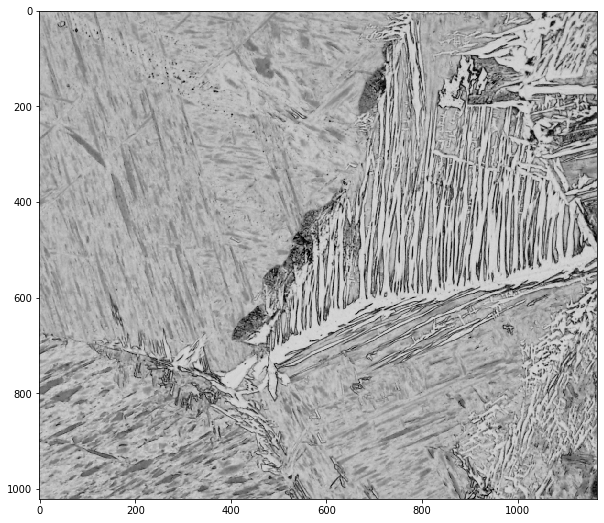

In [105]:
# Load and show the input image
filename = input('ENTER THE FILE NAME: ')
im = cv2.imread('/home/ubuntu/unsuper_seg/figures/' + filename)
plt.figure(figsize = (10,10))
plt.imshow(im)

# 2. Define variables and a model for training

In [106]:
# Variables
nChannel = 100 # default=100
maxIter = 2000 # default=1000
minLabels = 4  # default=3, determines the minimum number of labels for cnn training
learn_rate = 0.1 # default=0.1
nConv = 4 # default=2
num_superpixels = 4000 # default=10000, a lower number may yield a bad result
compactness_value = 20 # default = 100, optimal value is around 10

In [107]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        # size of the output: [(W−K+2P)/S]+1 in case of width
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        
        # Convolutional filters
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) ) 
            
        # Linear classifier
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        
        # Batch normalization
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [108]:
# Change the order of dimension: HEIGHT, WIDTH, CHANNEL --> CHANNEL, HEIGHT, WIDTH
im_trans = np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.])

# Change the type of data: numpy to torch
data = torch.from_numpy(im_trans)
data = Variable(data)
data = data.cuda()

# 3. SLIC superpixel segmentation

Text(0.5, 1.0, 'superpixel boundaries')

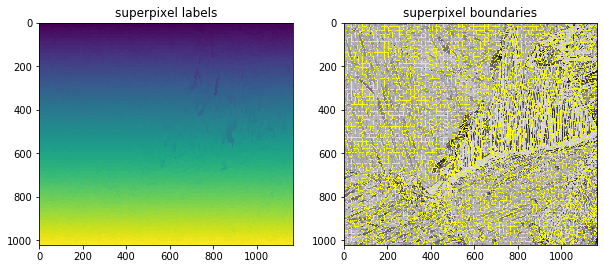

In [109]:
# Superpixels labels
labels = segmentation.slic(im, compactness=compactness_value, n_segments=num_superpixels)

# Superpixels boundaries
boundaries = segmentation.mark_boundaries(im, labels)

# Plot labels and boundaries
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.imshow(labels)
plt.title('superpixel labels')
fig.add_subplot(1,2,2)
plt.imshow(boundaries)
plt.title('superpixel boundaries')

In [110]:
# Reshape labels into 1D
labels = labels.reshape(im.shape[0]*im.shape[1])

# Extract unique labels
u_labels = np.unique(labels)

# l stands for location
'''
l_inds CONSISTS OF N SUPERPIXELS AS NUMPY ARRAYS.
EACH ELEMENT CONTAINS LOCATIONS OF EACH SUPERPIXEL.
'''

l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


# 4. Training

In [113]:
# Initialize model
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)

# Begin training
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if 0:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        cv2.imshow( "output", im_target_rgb )
        cv2.waitKey(10)

    # Superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', maxIter, ':', nLabels, loss.item())

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break




0 / 2000 : 100 4.4540205001831055
1 / 2000 : 100 4.067975997924805
2 / 2000 : 100 3.865659713745117
3 / 2000 : 98 3.7029378414154053
4 / 2000 : 85 3.5638136863708496
5 / 2000 : 78 3.4317922592163086
6 / 2000 : 65 3.268467664718628
7 / 2000 : 60 3.081231117248535
8 / 2000 : 56 2.89949893951416
9 / 2000 : 49 2.7207930088043213
10 / 2000 : 37 2.5364131927490234
11 / 2000 : 33 2.355612277984619
12 / 2000 : 31 2.180335521697998
13 / 2000 : 30 2.020321846008301
14 / 2000 : 22 1.8735508918762207
15 / 2000 : 20 1.7328355312347412
16 / 2000 : 14 1.6097533702850342
17 / 2000 : 11 1.4946072101593018
18 / 2000 : 9 1.3772141933441162
19 / 2000 : 8 1.2791359424591064
20 / 2000 : 8 1.177347183227539
21 / 2000 : 8 1.0740886926651
22 / 2000 : 9 0.9679958820343018
23 / 2000 : 8 0.8752908110618591
24 / 2000 : 8 0.7841997146606445
25 / 2000 : 7 0.7313297390937805
26 / 2000 : 6 0.667368471622467
27 / 2000 : 6 0.616032063961029
28 / 2000 : 5 0.5782715678215027
29 / 2000 : 4 0.5395957827568054
nLabels 4 reac

# 5. Plot and save the result

True

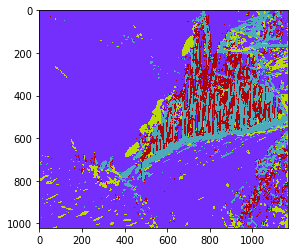

In [114]:
# DESIGNATE RANDOM COLORS TO CLASSES
label_colours = np.random.randint(255,size=(100,3))
output = model( data )[ 0 ]
output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
ignore, target = torch.max( output, 1 )
im_target = target.data.cpu().numpy()
output_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
plt.imshow(output_rgb.reshape(im.shape))
cv2.imwrite('/home/ubuntu/unsuper_seg/results/'+'output_' + filename, output_rgb.reshape(im.shape) )